In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gp

In [2]:
import os
import json
wd = os.getcwd()
wd_list = wd.split("/")
unique_path = "/".join(wd_list[1:3])
#I have the passwords file saved as 'nothing_to_see_here.json'. Super secure, I know
path = "/"+unique_path+"/esh/nothing_to_see_here.json"
#Load json file in .esh and get into creds
#This accesses for the db_creds dictionary specifically. Other dicts are available by changing the ref below
creds = json.load(open(path))['db_creds']
from sqlalchemy import create_engine
import os
###DONT SHARE WITH LOGIN DETAILS###
POSTGRES_ADDRESS = creds['esh_db_address']
POSTGRES_PORT =  creds['esh_db_port']
POSTGRES_USERNAME = creds['esh_db_username']
POSTGRES_PASSWORD = creds['esh_db_password']
POSTGRES_DBNAME = creds['esh_db_name']
# A long string that contains the necessary Postgres login information
postgres_str = ('postgresql://{username}:{password}@{ipaddress}:{port}/{dbname}'.format(username=POSTGRES_USERNAME,
                password=POSTGRES_PASSWORD,ipaddress=POSTGRES_ADDRESS,port=POSTGRES_PORT,dbname=POSTGRES_DBNAME))
# Create the connection
cnx = create_engine(postgres_str)

In [45]:
query = '''
WITH df as (
    SELECT 
        --identifying info
        --NOTE: using puma 2010 ID's to match crosswalk file
        hh.state_id, hh.puma20_id, hh.serialno, 
        --poverty level as pct of FPL
        MAX(pop.povpip) as povpip,
        -- eligibility
        MAX(
            CASE WHEN (pop.hins4::text = '1'::text OR 
                        hh.fs::text = '1'::text OR
                        pop.pap > 0::numeric OR
                        pop.ssip > 0::numeric OR 
                        pop.povpip <= 200::numeric) 
            THEN 1
            ELSE 0 END) as pbb_eligible,
        --unconnected
        MAX(
            CASE WHEN  hh.accessinet::text = '3'::text OR
                            (hh.accessinet::text = '1'::text AND 
                             hh.hispeed::text = '2'::text AND 
                             hh.othsvcex::text = '2'::text AND 
                             (hh.dialup::text = '1'::text OR hh.dialup::text = '2'::text) AND 
                             hh.satellite::text = '2'::text) 
                THEN 1
                ELSE 0 END) AS unconnected,
            --demographic info
            --veteran
            MAX(CASE WHEN pop.vps IN ('01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14')
               THEN 1
               ELSE 0 END) as veteran,
            --senior
            MAX(CASE WHEN hh.r65 IN ('1','2')
                THEN 1
                ELSE 0 END) as senior,
            --black
            MAX(CASE WHEN pop.racblk = '1' 
               THEN 1
               ELSE 0 END) as black,
            --latinx
            MAX(CASE WHEN pop.hisp IN ('02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24'
            )THEN 1	
               ELSE 0 END) as latinx,
            MAX(hh.wgtp) as hh_weight
            FROM dl.pums_households_2022 hh
            LEFT JOIN dl.pums_population_2022 pop ON hh.puma20_id::text = pop.puma20_id::text AND hh.serialno::text = pop.serialno::text
            WHERE hh.wgtp > 0
            GROUP BY hh.state_id, hh.serialno, hh.puma20_id,hh.accessinet, hh.hispeed, hh.othsvcex, hh.dialup, hh.satellite
    )

SELECT state_id, puma20_id, serialno, 
hh_weight, povpip,
--for vets
CASE WHEN veteran = 1 THEN hh_weight
ELSE NULL END  as hh_weight_vet,
CASE WHEN veteran = 1 THEN povpip
ELSE NULL END  as pov_vet

FROM df

WHERE pbb_eligible = 1 AND unconnected = 1
'''

In [46]:
df = pd.read_sql(query, cnx)
df.head()

,state_id,puma20_id,serialno,hh_weight,povpip,hh_weight_vet,pov_vet
0,01,01-0009,2018HU0000680,1.0,35.0,NaN,NaN
1,01,01-0009,2018HU0000969,12.0,45.0,NaN,NaN
2,01,01-0009,2018HU0001042,3.0,135.0,3.0,135.0
3,01,01-0009,2018HU0001052,17.0,132.0,NaN,NaN
4,01,01-0009,2018HU0001456,3.0,142.0,NaN,NaN


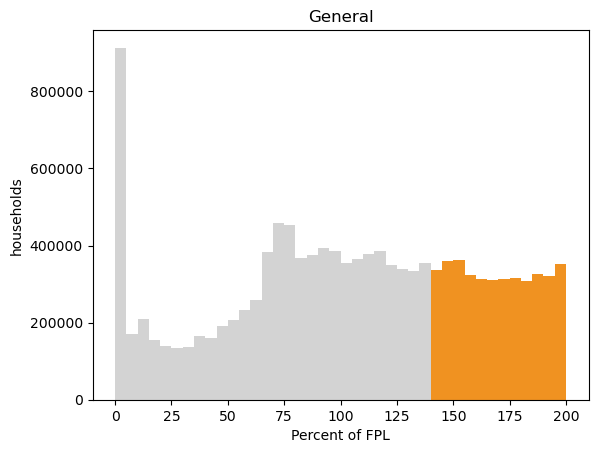

In [47]:
#filter down to values of povpip between 0 and 200

df_filt = df[df['povpip']<=200]

#plot histogram
hist_values, bin_edges, patches = plt.hist(
    df_filt['povpip'],
    bins=np.arange(0, 201,5),  # Adjust bin size as needed
    weights=df_filt['hh_weight'],          # Weight the values by hh_weight
    )
for i, patch in enumerate(patches):
    if bin_edges[i] <= 135:
        patch.set_facecolor('lightgrey')          # Set bars from 0 to 135 to grey
    else:
        patch.set_facecolor('#F09221')        # Set bars from 135 to 200 to orange


plt.title('General')
plt.xlabel('Percent of FPL')
plt.ylabel('households')
plt.show()

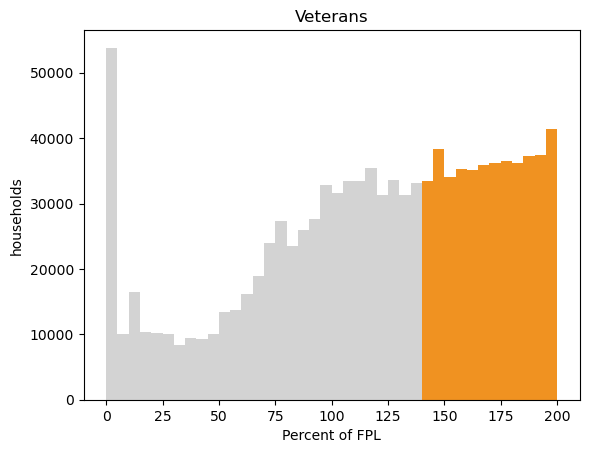

In [48]:
#create a df for vets
vet = df[df['pov_vet']<=200].dropna()

hist_values, bin_edges, patches = plt.hist(
    vet['pov_vet'],
    bins=np.arange(0, 201, 5),  # Adjust bin size as needed
    weights=vet['hh_weight_vet'],          # Weight the values by hh_weight
    #edgecolor='black'
    )
for i, patch in enumerate(patches):
    if bin_edges[i] <= 135:
        patch.set_facecolor('lightgrey')          # Set bars from 0 to 135 to grey
    else:
        patch.set_facecolor('#F09221')        # Set bars from 135 to 200 to orange


plt.title('Veterans')
plt.xlabel('Percent of FPL')
plt.ylabel('households')
plt.show()

In [52]:
hh_delta = df[(df['povpip']>=135)&(df['povpip']<=200)]['hh_weight'].sum()
print(str(hh_delta)+' households between 135% and 200%')

pbb_eligible = df['hh_weight'].sum()
print(str(check) +' households eligible for pbb')

pct_delta = round(hh_delta / pbb_eligible, 2)
print(str(pct_delta) + ' pct of eligible households between 135% and 200%')

vet_elig = df['hh_weight_vet'].sum()
print(str(vet_elig) + ' veteran households eligible for PBB')

vet_elig_delta = df[(df['povpip']>=135) & (df['povpip']<=200)]['hh_weight_vet'].sum()
print(str(vet_elig_delta) + ' Veteran households eligible for PBB between 135 and 200')

vet_pct_delta = round(vet_elig_delta/vet_elig, 3)
print(str(vet_pct_delta) + ' pct of eligible VETERAN households between 135% and 200%')

4294701.0 households between 135% and 200%
16323551.0 households eligible for pbb
0.26 pct of eligible households between 135% and 200%
1582100.0 veteran households eligible for PBB
470268.0 Veteran households eligible for PBB between 135 and 200
0.297 pct of eligible VETERAN households between 135% and 200%
